In [5]:
def one_hot_encoding(labels, num_classes=10):
    """
    Encode labels using one hot encoding and return them.
    """
    values = labels
    n_values = np.max(labels) + 1
    return np.eye(n_values)[labels] 


def write_to_file(path, data):
    """
    Dumps pickled data into the specified relative path.

    Args:
        path: relative path to store to
        data: data to pickle and store
    """
    with open(path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_data(train=True):
    """
    Load the data from disk

    Args:
        train: Load training data if true, else load test data

    Returns:
        Tuple:
            Images
            Labels
    """
    directory = 'train' if train else 'test'
    patterns = np.load(os.path.join('./data/', directory, 'images.npz'))['arr_0']
    labels = np.load(os.path.join('./data/', directory, 'labels.npz'))['arr_0']
    return patterns.reshape(len(patterns), -1), labels


def load_config(path):
    """
    Load the configuration from config.yaml

    Args:
        path: A relative path to the config.yaml file

    Returns:
        A dict object containing the parameters specified in the config file
    """
    return yaml.load(open(path, 'r'), Loader=yaml.SafeLoader)


def generate_k_fold_set(dataset, k=5):
    """
    Creates a generator object to generate k folds for k fold cross validation.

    Args:
        dataset: The dataset to create folds on
        k: The number of folds

    Returns:
        A train and validation fold for each call, up to k times
    """
    X, y = dataset
    if k == 1:
        yield (X, y), (X[len(X):], y[len(y):])
        return

    order = np.random.permutation(len(X))

    fold_width = len(X) // k

    l_idx, r_idx = 0, fold_width

    for i in range(k):
        train = np.concatenate([X[order[:l_idx]], X[order[r_idx:]]]), np.concatenate(
            [y[order[:l_idx]], y[order[r_idx:]]])
        validation = X[order[l_idx:r_idx]], y[order[l_idx:r_idx]]
        yield train, validation
        l_idx, r_idx = r_idx, r_idx + fold_width


def z_score_normalize(X, u=None, sd=None):
    """
    Performs z-score normalization on X.
    f(x) = (x - μ) / σ
        where
            μ = mean of x
            σ = standard deviation of x

    Args:
        X: the data to min-max normalize
        u: the mean to normalize X with
        sd: the standard deviation to normalize X with

    Returns:
        Tuple:
            Transformed dataset with mean 0 and stdev 1
            Computed statistics (mean and stdev) for the dataset to undo z-scoring.

    """
    if u is None:
        u = np.mean(X, axis=0)
    if sd is None:
        sd = np.std(X, axis=0)
    return ((X - u) / sd), (u, sd)


In [6]:
def z_score_normalize(X, u=None, sd=None):
    """
    Performs z-score normalization on X.
    f(x) = (x - μ) / σ
        where
            μ = mean of x
            σ = standard deviation of x

    Args:
        X: the data to min-max normalize
        u: the mean to normalize X with
        sd: the standard deviation to normalize X with

    Returns:
        Tuple:
            Transformed dataset with mean 0 and stdev 1
            Computed statistics (mean and stdev) for the dataset to undo z-scoring.

    """
    if u is None:
        u = np.mean(X, axis=0)
    if sd is None:
        sd = np.std(X, axis=0)
    return ((X - u) / sd), (u, sd)

def shuffle(dataset):
    """
    Shuffle dataset.
    Make sure that corresponding images and labels are kept together. 
    Ideas: 
        NumPy array indexing 
            https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing
    Parameters
    ----------
    dataset
        Tuple containing
            Images (X)
            Labels (y)
    Returns
    -------
        Tuple containing
            Images (X)
            Labels (y)
    """
    dim=dataset[0].shape[0]
    index1=np.arange(dim)
    np.random.shuffle(index1)
    shuffled_data=dataset[0][index1]
    shuffled_label=dataset[1][index1]
    return (shuffled_data,shuffled_label)

In [9]:
import os
import pickle

import numpy as np
import yaml

# Without Regularization

In [223]:
# import numpy as np
# import math
# import matplotlib.pyplot as plt


# class Activation:
#     """
#     The class implements different types of activation functions for
#     your neural network layers.

#     Example (for sigmoid):
#         >>> sigmoid_layer = Activation("sigmoid")
#         >>> z = sigmoid_layer(a)
#         >>> gradient = sigmoid_layer.backward(delta)
#     """

#     def __init__(self, activation_type="sigmoid"):
#         """
#         Initialize activation type and placeholders here.
#         """
#         if activation_type not in ["sigmoid", "tanh", "ReLU"]:
#             raise NotImplementedError("%s is not implemented." % (activation_type))

#         # Type of non-linear activation.
#         self.activation_type = activation_type
#         # Placeholder for input. This will be used for computing gradients.
#         # Remember from my write up that a is a J*N matrix, where J is number of units being connected 
#         # and N is number of data points in our minibatch.
#         self.x = None
        
#         # State the type of the layer to differentiate from normal layer
#         self.type="activation"

#     def __call__(self, a):
#         """
#         This method allows your instances to be callable.
#         """
#         # We need to save this vector, a, for computing the gradient evaluated at a.
#         self.x=a
#         return self.forward(a)

#     def forward(self, a):
#         """
#         Compute the forward pass.
#         """
        
        
#         if self.activation_type == "sigmoid":
#             return self.sigmoid(a)

#         elif self.activation_type == "tanh":
#             return self.tanh(a)

#         elif self.activation_type == "ReLU":
#             return self.ReLU(a)

#     def backward(self, delta):
#         """
#         Compute the backward pass.
#         """
#         if self.activation_type == "sigmoid":
#             grad = self.grad_sigmoid()

#         elif self.activation_type == "tanh":
#             grad = self.grad_tanh()

#         elif self.activation_type == "ReLU":
#             grad = self.grad_ReLU()

#         return grad * delta

#     def sigmoid(self, x):
#         """
#         Implement the sigmoid activation here.
#         Notice that I implement the clipping to avoid numerical overflow 
#         """
#         x=np.clip(x,-20,20)
#         return 1/(1+np.exp(-x))

#     def tanh(self, x):
#         """
#         Implement tanh here.
#         """
#         return 1.7159*np.tanh((2/3)*x)
        

#     def ReLU(self, x):
#         """
#         Implement ReLU here.
#         """
#         # Apply element-wise relu to a given matrix element-wise
       
#         return np.clip(self.x,0,a_max=200)

#     def grad_sigmoid(self):
#         """
#         Compute the gradient for sigmoid here.
#         """
#         return self.sigmoid(self.x)*(1-self.sigmoid(self.x))

#     def grad_tanh(self):
#         """
#         Compute the gradient for tanh here.
#         """
#         return 1-np.square(np.tanh(self.x))

#     def grad_ReLU(self):
#         """
#         Compute the gradient for ReLU here.
#         """
#         original_shape=self.x.shape
#         x=self.x.flatten()
#         out=[]
#         for i in range(len(x)):
#             if x[i]>=0:
#                 out.append(1)
#             else:
#                 out.append(0)
#         out=np.array(out)
#         return out.reshape(original_shape)


# class Layer:
#     """
#     This class implements Fully Connected layers for your neural network.

#     Example:
#         >>> fully_connected_layer = Layer(1024, 100)
#         >>> output = fully_connected_layer(input)
#         >>> gradient = fully_connected_layer.backward(delta)
#     """

#     def __init__(self, in_units, out_units):
#         """
#         Define the architecture and create placeholder.
#         """        
        
#         np.random.seed(42)
#         self.w = math.sqrt(2 / in_units) * np.random.randn(in_units,
#                                                            out_units)  # You can experiment with initialization.
#         # Notice that the dimension 1*M is suffice due to the fact array can be broadcasted
#         self.b = np.random.randn(1, out_units).flatten()  # Create a placeholder for Bias; 
#         self.x = None  # Save the input to forward in this; This is dimension of N*j.
#         self.a = None  # Save the output of forward pass in this (without activation)

#         self.d_x = None  # Save the gradient w.r.t x in this
#         self.d_w = None  # Save the gradient w.r.t w in this
#         self.d_b = None  # Save the gradient w.r.t b in this


#         self.prev_d_w=None
        
#         # State the type of the layer to differentiate from activation layer
#         self.type="layer"

#     def __call__(self, x):
#         """
#         Make layer callable.
#         """
#         self.x=x
#         return self.forward(x)

#     def forward(self, x):
#         """
#         Compute the forward pass through the layer here.
#         Do not apply activation here.
#         Return self.a
#         """
        
#         self.a=np.matmul(self.x,self.w)+self.b # save the value for a;
        
        
#         return self.a
#     def backward(self, delta):
#         """
#         Write the code for backward pass. This takes in gradient from its next layer as input,
#         computes gradient for its weights and the delta to pass to its previous layers.
#         Return self.dx
#         """
        
#         # the delta matrix from next layer have the dimentionality of N*F
#         # Right after ariive this layer they become N*M 
#         self.prev_d_w=self.d_w # we define this for the purpose of apply momentum 
#         self.d_w=np.matmul(self.x.T,delta) 
        
        

#         # Now let's compute the d_b=delta*1
#         # Its' vectorized form is 1*n vector(all ones since it's bias) *  n*M delta.
#         bias_units=np.ones((1, len(self.x))).flatten()
#         self.d_b=np.matmul(bias_units,delta)
        

#         # Then we should compute the weighted sum of the delta and pass it to the activation layer 
#         # In previous layer(activation layer). The full delta will be computed.
#         # delta:N*M w:J*M (The notation switch here )
#         # store weighted sum of delta as dx.
        
        
#         self.d_x=np.matmul(delta,self.w.T)

#         return self.d_x


# class NeuralNetwork:
#     """
#     Create a Neural Network specified by the input configuration.

#     Example:
#         >>> net = NeuralNetwork(config)
#         >>> output = net(input)
#         >>> net.backward()
#     """

#     def __init__(self, config):
#         """
#         Create the Neural Network using config.
#         """
#         self.layers = []  # Store all layers in this list.
#         self.x = None  # Save the input to forward in this
#         self.y = None  # Save the output vector of model in this
#         self.targets = None  # Save the targets in forward in this variable

#         # Add layers specified by layer_specs.
#         for i in range(len(config['layer_specs']) - 1):
#             self.layers.append(Layer(config['layer_specs'][i], config['layer_specs'][i + 1]))
#             if i < len(config['layer_specs']) - 2:
#                 self.layers.append(Activation(config['activation']))

#     def __call__(self, x, targets=None):
#         """
#         Make NeuralNetwork callable.
#         """
        
#         return self.forward(x, targets)

#     def forward(self, x, targets=None):
#         """
#         Compute forward pass through all the layers in the network and return it.
#         If targets are provided, return loss as well.
#         """
        
#         # Save the data here. 
#         self.x=x
#         self.targets=targets

#         # Now we are going to loop through each and every layer of our network. 
#         # our input signal will pass through these successive networks 
#         for i in self.layers:
#             out=i(self.x) # Compute the output signal from a layer
#             self.x=out # Store the output signal for latar use 
            
            

#         # Remeber that the last layer of the network is the output layer, which must
#         # be gone through softmax transformation. 
#         self.y=self.softmax(self.x)
        
        
#         if targets is not None:
#             loss=self.loss(self.y,self.targets)
#             return (self.y,loss)

#         return self.y

#     def backward(self):
#         """
#         Implement backpropagation here.
#         Call backward methods of individual layer's.
#         """

#         # Get the necessary parameters for optimization. 
#         learning_rate=config["learning_rate"]
#         L2_penalty=config["L2_penalty"]
#         if_momentum=config["momentum"]
#         momentum_gamma=config["momentum_gamma"]

#         # before we start, we can compute the error signal. 
#         error_signal=self.targets-self.y
        
#         for i in range(len(self.layers)):
            
#             # Use negative indexing to travel backward.
#             current_layer=self.layers[-(i+1)]
#             # Feed in the current error signal and update error signal(delta) to the previous layer 
#             # Error signal here is just the weighted sum of delta
#             error_signal=current_layer.backward(error_signal)
#             # Update the weights and bias term based on gradient descent 
#             # During the update, per specification of the user, momentum and L2 regularization will be involved
#             # So, our new weight change: Gamma*old_weight_change+(1-Gamma)*new_weight_change-2*lambda*w
            
#             # Need to notice that we only update the weights if the layer is not activation layer.
#             if current_layer.type=="layer":
#                 if if_momentum:
#                     if current_layer.prev_d_w is None: # This happens during the first weight update 
#                         # Don't be confused by minus sign here. I do this becasue w=w+a*d_w; all signs are just flipped
#                         combined_weight_change=current_layer.d_w-2*L2_penalty*current_layer.w
#                     else:  
#                         combined_weight_change=momentum_gamma*current_layer.prev_d_w+(1-momentum_gamma)*current_layer.d_w-2*L2_penalty*current_layer.w
#                 else:
#                     # Ignore the momentum term all the time; 
#                     combined_weight_change=current_layer.d_w-2*L2_penalty*current_layer.w

#                 current_layer.w=current_layer.w+learning_rate*combined_weight_change


#     def softmax(self, x):
#         """
#         Implement the softmax function here.
#         Remember to take care of the overflow condition.
#         """
#         a=x
#         a=np.clip(a,-20,20)
#         a_exp = np.exp(a)
#         partition = np.sum(a_exp, axis=1).reshape(-1,1)
#         return a_exp / partition

#     def loss(self, logits, targets):
#         """
#         Compute the categorical cross-entropy loss and return it.
#         """
#         # We reuse the code for logistic regression.
#         y=logits
#         t=targets
#         entropy=np.zeros(t.shape[0])
#         for i in range(10):
#             target_column=t[:,i]
#             prediction_column=y[:,i]
#             entropy+=target_column*np.log(prediction_column)
#         return -np.mean(entropy/10)
    
    

# def train(x_train_in, y_train_in, x_val, y_val, config, experiment=None):
#     """
#     Train your model here using batch stochastic gradient descent and early stopping. Use config to set parameters
#     for training like learning rate, momentum, etc.

#     Args:
#         x_train: The train patterns
#         y_train: The train labels; 
#         x_val: The validation set patterns
#         y_val: The validation set labels
#         config: The configs as specified in config.yaml
#         experiment: An optional dict parameter for you to specify which experiment you want to run in train.

#     Returns:
#         5 things:
#             training and validation loss and accuracies - 1D arrays of loss and accuracy values per epoch.
#             best model - an instance of class NeuralNetwork. You can use copy.deepcopy(model) to save the best model.
#     """
#     train_acc = []
#     val_acc = []
#     train_loss = []
#     val_loss = []
#     best_model = None

#     model = NeuralNetwork(config=config)

#     # Read in some of the model parameters:
#     epochs=config["epochs"]
#     if_early_stop=config["early_stop"]
#     early_stop_epoch=config['early_stop_epoch']
#     batch_size=config["batch_size"]
    
#     y_train_in=one_hot_encoding(y_train_in)
#     train_dataset=(x_train_in,y_train_in)

#     # Determine the number of iterations that will be used fortraining
#     terations_num=None

#     if if_early_stop:
#         iterations_num=early_stop_epoch
#     else:
#         iterations_num=epochs
        

#     for i in range(iterations_num):
#         # shuffle the dataset and generate minibatchs. 
#         train_dataset=shuffle(train_dataset)
#         for X_train,y_train in generate_minibatches(train_dataset,batch_size=batch_size):
#             # A forward pass to make prediction
#             model(X_train,targets=y_train)
#             # A backward pass to adjust the weights 
#             model.backward()
#         # Evaluate model's performance on training set. 
#         predictions,loss=model.forward(x_train_in,targets=y_train_in)
#         predicted_labels=np.argmax(predictions,axis=1)
#         restored_labels=np.argmax(y_train_in,axis=1)
#         single_accuracy=np.mean(predicted_labels== restored_labels)
#         train_acc.append(single_accuracy)
#         train_loss.append(loss)
#         # Evaluate model's performance on validation set.
#         val_oh=one_hot_encoding(y_val)
#         p1,l2=model.forward(x_val,targets=val_oh)
#         predicted=np.argmax(p1,axis=1)
#         acc=np.mean(predicted==y_val)
#         val_acc.append(acc)
#         val_loss.append(l2)
    
#     return train_acc, val_acc, train_loss, val_loss, model



# def test(model, x_test, y_test):
#     """
#     Does a forward pass on the model and returns loss and accuracy on the test set.

#     Args:
#         model: The trained model to run a forward pass on.
#         x_test: The test patterns.
#         y_test: The test labels.

#     Returns:
#         Loss, Test accuracy
#     """
#     # return loss, accuracy
#     y_test_oh=one_hot_encoding(y_test)
#     test_prediction,test_loss=model.forward(x_test,targets=y_test_oh)
#     test_labels_predicted=np.argmax(test_prediction,axis=1)
#     return test_loss,np.mean(test_labels_predicted==y_test)

# with no regularization

In [361]:
import numpy as np
import math
import matplotlib.pyplot as plt


class Activation:
    """
    The class implements different types of activation functions for
    your neural network layers.

    Example (for sigmoid):
        >>> sigmoid_layer = Activation("sigmoid")
        >>> z = sigmoid_layer(a)
        >>> gradient = sigmoid_layer.backward(delta)
    """

    def __init__(self, activation_type="sigmoid"):
        """
        Initialize activation type and placeholders here.
        """
        if activation_type not in ["sigmoid", "tanh", "ReLU"]:
            raise NotImplementedError("%s is not implemented." % (activation_type))

        # Type of non-linear activation.
        self.activation_type = activation_type
        # Placeholder for input. This will be used for computing gradients.
        # Remember from my write up that a is a J*N matrix, where J is number of units being connected 
        # and N is number of data points in our minibatch.
        self.x = None
        
        # State the type of the layer to differentiate from normal layer
        self.type="activation"

    def __call__(self, a):
        """
        This method allows your instances to be callable.
        """
        # We need to save this vector, a, for computing the gradient evaluated at a.
        self.x=a
        return self.forward(a)

    def forward(self, a):
        """
        Compute the forward pass.
        """
        
        
        if self.activation_type == "sigmoid":
            return self.sigmoid(a)

        elif self.activation_type == "tanh":
            return self.tanh(a)

        elif self.activation_type == "ReLU":
            return self.ReLU(a)

    def backward(self, delta):
        """
        Compute the backward pass.
        """
        if self.activation_type == "sigmoid":
            grad = self.grad_sigmoid()

        elif self.activation_type == "tanh":
            grad = self.grad_tanh()

        elif self.activation_type == "ReLU":
            grad = self.grad_ReLU()

        return grad * delta

    def sigmoid(self, x):
        """
        Implement the sigmoid activation here.
        Notice that I implement the clipping to avoid numerical overflow 
        """
        x=np.clip(x,-20,20)
        return 1/(1+np.exp(-x))

    def tanh(self, x):
        """
        Implement tanh here.
        """
        return 1.7159*np.tanh((2/3)*x)
        

    def ReLU(self, x):
        """
        Implement ReLU here.
        """
        # Apply element-wise relu to a given matrix element-wise
       
        return np.clip(self.x,0,a_max=200)

    def grad_sigmoid(self):
        """
        Compute the gradient for sigmoid here.
        """
        return self.sigmoid(self.x)*(1-self.sigmoid(self.x))

    def grad_tanh(self):
        """
        Compute the gradient for tanh here.
        """
        return 1-np.square(np.tanh(self.x))

    def grad_ReLU(self):
        """
        Compute the gradient for ReLU here.
        """
        original_shape=self.x.shape
        x=self.x.flatten()
        out=[]
        for i in range(len(x)):
            if x[i]>=0:
                out.append(1)
            else:
                out.append(0)
        out=np.array(out)
        return out.reshape(original_shape)


class Layer:
    """
    This class implements Fully Connected layers for your neural network.

    Example:
        >>> fully_connected_layer = Layer(1024, 100)
        >>> output = fully_connected_layer(input)
        >>> gradient = fully_connected_layer.backward(delta)
    """

    def __init__(self, in_units, out_units):
        """
        Define the architecture and create placeholder.
        """        
        
        np.random.seed(42)
        self.w = math.sqrt(2 / in_units) * np.random.randn(in_units,
                                                           out_units)  # You can experiment with initialization.
        # Notice that the dimension 1*M is suffice due to the fact array can be broadcasted
        self.b = np.random.randn(1, out_units).flatten()  # Create a placeholder for Bias; 
        self.x = None  # Save the input to forward in this; This is dimension of N*j.
        self.a = None  # Save the output of forward pass in this (without activation)

        self.d_x = None  # Save the gradient w.r.t x in this
        self.d_w = None  # Save the gradient w.r.t w in this
        self.d_b = None  # Save the gradient w.r.t b in this


        self.prev_d_w=None
        
        # State the type of the layer to differentiate from activation layer
        self.type="layer"

    def __call__(self, x):
        """
        Make layer callable.
        """
        self.x=x
        return self.forward(x)

    def forward(self, x):
        """
        Compute the forward pass through the layer here.
        Do not apply activation here.
        Return self.a
        """
        
        self.a=np.matmul(self.x,self.w)+self.b # save the value for a;
        
        
        return self.a
    def backward(self, delta):
        """
        Write the code for backward pass. This takes in gradient from its next layer as input,
        computes gradient for its weights and the delta to pass to its previous layers.
        Return self.dx
        """
        
        # the delta matrix from next layer have the dimentionality of N*F
        # Right after ariive this layer they become N*M 
        self.prev_d_w=self.d_w # we define this for the purpose of apply momentum 
        
        #l2 regularization
        #self.d_w=np.matmul(self.x.T,delta) - 0.0000001 * self.w
        
        #l1 regularization
        self.d_w=np.matmul(self.x.T,delta) - 0.0001 * 1
        
        

        # Now let's compute the d_b=delta*1
        # Its' vectorized form is 1*n vector(all ones since it's bias) *  n*M delta.
        bias_units=np.ones((1, len(self.x))).flatten()
        self.d_b=np.matmul(bias_units,delta)
        

        # Then we should compute the weighted sum of the delta and pass it to the activation layer 
        # In previous layer(activation layer). The full delta will be computed.
        # delta:N*M w:J*M (The notation switch here )
        # store weighted sum of delta as dx.
        
        
        self.d_x=np.matmul(delta,self.w.T)

        return self.d_x


class NeuralNetwork:
    """
    Create a Neural Network specified by the input configuration.

    Example:
        >>> net = NeuralNetwork(config)
        >>> output = net(input)
        >>> net.backward()
    """

    def __init__(self, config):
        """
        Create the Neural Network using config.
        """
        self.layers = []  # Store all layers in this list.
        self.x = None  # Save the input to forward in this
        self.y = None  # Save the output vector of model in this
        self.targets = None  # Save the targets in forward in this variable

        # Add layers specified by layer_specs.
        for i in range(len(config['layer_specs']) - 1):
            self.layers.append(Layer(config['layer_specs'][i], config['layer_specs'][i + 1]))
            if i < len(config['layer_specs']) - 2:
                self.layers.append(Activation(config['activation']))

    def __call__(self, x, targets=None):
        """
        Make NeuralNetwork callable.
        """
        
        return self.forward(x, targets)

    def forward(self, x, targets=None):
        """
        Compute forward pass through all the layers in the network and return it.
        If targets are provided, return loss as well.
        """
        
        # Save the data here. 
        self.x=x
        self.targets=targets

        # Now we are going to loop through each and every layer of our network. 
        # our input signal will pass through these successive networks 
        for i in self.layers:
            out=i(self.x) # Compute the output signal from a layer
            self.x=out # Store the output signal for latar use 
            
            

        # Remeber that the last layer of the network is the output layer, which must
        # be gone through softmax transformation. 
        self.y=self.softmax(self.x)
        
        
        if targets is not None:
            loss=self.loss(self.y,self.targets)

            # regularization
            for i, layer in enumerate(self.layers):
                if i%2==0:
                    #l2 regularization
#                     loss += 0.5 * 0.0000001 * np.sum(layer.w)
                    
                    #l1 regularization
                    loss += 0.5 * 0.0001 * np.sum(np.abs(layer.w))

            return (self.y,loss)

        return self.y

    def backward(self):
        """
        Implement backpropagation here.
        Call backward methods of individual layer's.
        """

        # Get the necessary parameters for optimization. 
        learning_rate=config["learning_rate"]
        L2_penalty=config["L2_penalty"]
        if_momentum=config["momentum"]
        momentum_gamma=config["momentum_gamma"]

        # before we start, we can compute the error signal. 
        error_signal=self.targets-self.y
        
        for i in range(len(self.layers)):
            
            # Use negative indexing to travel backward.
            current_layer=self.layers[-(i+1)]
            # Feed in the current error signal and update error signal(delta) to the previous layer 
            # Error signal here is just the weighted sum of delta
            error_signal=current_layer.backward(error_signal)
            # Update the weights and bias term based on gradient descent 
            # During the update, per specification of the user, momentum and L2 regularization will be involved
            # So, our new weight change: Gamma*old_weight_change+(1-Gamma)*new_weight_change-2*lambda*w
            
            # Need to notice that we only update the weights if the layer is not activation layer.
            if current_layer.type=="layer":
                if if_momentum:
                    if current_layer.prev_d_w is None: # This happens during the first weight update 
                        # Don't be confused by minus sign here. I do this becasue w=w+a*d_w; all signs are just flipped
                        combined_weight_change=current_layer.d_w-2*L2_penalty*current_layer.w
                    else:  
                        combined_weight_change=momentum_gamma*current_layer.prev_d_w+(1-momentum_gamma)*current_layer.d_w-2*L2_penalty*current_layer.w
                else:
                    # Ignore the momentum term all the time; 
                    combined_weight_change=current_layer.d_w-2*L2_penalty*current_layer.w

                current_layer.w=current_layer.w+learning_rate*combined_weight_change


    def softmax(self, x):
        """
        Implement the softmax function here.
        Remember to take care of the overflow condition.
        """
        a=x
        a=np.clip(a,-20,20)
        a_exp = np.exp(a)
        partition = np.sum(a_exp, axis=1).reshape(-1,1)
        return a_exp / partition

    def loss(self, logits, targets):
        """
        Compute the categorical cross-entropy loss and return it.
        """
        # We reuse the code for logistic regression.
        y=logits
        t=targets
        entropy=np.zeros(t.shape[0])
        for i in range(10):
            target_column=t[:,i]
            prediction_column=y[:,i]
            entropy+=target_column*np.log(prediction_column)
        return -np.mean(entropy/10)
    
    

def train(x_train_in, y_train_in, x_val, y_val, config, experiment=None):
    """
    Train your model here using batch stochastic gradient descent and early stopping. Use config to set parameters
    for training like learning rate, momentum, etc.

    Args:
        x_train: The train patterns
        y_train: The train labels; 
        x_val: The validation set patterns
        y_val: The validation set labels
        config: The configs as specified in config.yaml
        experiment: An optional dict parameter for you to specify which experiment you want to run in train.

    Returns:
        5 things:
            training and validation loss and accuracies - 1D arrays of loss and accuracy values per epoch.
            best model - an instance of class NeuralNetwork. You can use copy.deepcopy(model) to save the best model.
    """
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    best_model = None

    model = NeuralNetwork(config=config)

    # Read in some of the model parameters:
    epochs=config["epochs"]
    if_early_stop=config["early_stop"]
    early_stop_epoch=config['early_stop_epoch']
    batch_size=config["batch_size"]
    
    y_train_in=one_hot_encoding(y_train_in)
    train_dataset=(x_train_in,y_train_in)

    # Determine the number of iterations that will be used fortraining
    terations_num=None

    if if_early_stop:
        iterations_num=early_stop_epoch
    else:
        iterations_num=epochs
        

    for i in range(iterations_num):
        # shuffle the dataset and generate minibatchs. 
        train_dataset=shuffle(train_dataset)
        for X_train,y_train in generate_minibatches(train_dataset,batch_size=batch_size):
            # A forward pass to make prediction
            model(X_train,targets=y_train)
            # A backward pass to adjust the weights 
            model.backward()
        # Evaluate model's performance on training set. 
        predictions,loss=model.forward(x_train_in,targets=y_train_in)
        predicted_labels=np.argmax(predictions,axis=1)
        restored_labels=np.argmax(y_train_in,axis=1)
        single_accuracy=np.mean(predicted_labels== restored_labels)
        train_acc.append(single_accuracy)
        train_loss.append(loss)
        # Evaluate model's performance on validation set.
        val_oh=one_hot_encoding(y_val)
        p1,l2=model.forward(x_val,targets=val_oh)
        predicted=np.argmax(p1,axis=1)
        acc=np.mean(predicted==y_val)
        val_acc.append(acc)
        val_loss.append(l2)
    
    return train_acc, val_acc, train_loss, val_loss, model



def test(model, x_test, y_test):
    """
    Does a forward pass on the model and returns loss and accuracy on the test set.

    Args:
        model: The trained model to run a forward pass on.
        x_test: The test patterns.
        y_test: The test labels.

    Returns:
        Loss, Test accuracy
    """
    # return loss, accuracy
    y_test_oh=one_hot_encoding(y_test)
    test_prediction,test_loss=model.forward(x_test,targets=y_test_oh)
    test_labels_predicted=np.argmax(test_prediction,axis=1)
    return test_loss,np.mean(test_labels_predicted==y_test)

In [362]:
# Load the data and perform train-validation split
train_data=load_data(train=True)
data=shuffle(train_data)
tra_data,b=z_score_normalize(data[0][0:48000,:])
val_data,b=z_score_normalize(data[0][48000:,:])
tra_labels=data[1][0:48000]
val_labels=data[1][48000:]
test_data=load_data(train=False)
x_test,a=z_score_normalize(test_data[0])
y_test=test_data[1]

In [363]:
config = load_config("./config.yaml")

# Regularization --- L2/L1

In [364]:
# Customize the parameters for quik check.
config["layer_specs"]=[784, 128, 10]
config["batch_size"]=129
config["early_stop"]=True
config["early_stop_epoch"]=25
config["activation"]="tanh"
config["learning_rate"]=0.0005
config["epochs"]=100
config["L2_penalty"]=0.0001
config["momentum"]=True
config["momentum_gamma"]=0.9

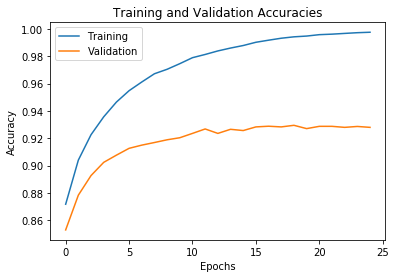

In [365]:
train_acc, valid_acc, train_loss, valid_loss, best_model=train(tra_data, tra_labels, val_data, val_labels, config)
plt.plot(train_acc, label='Training')
plt.plot(valid_acc, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

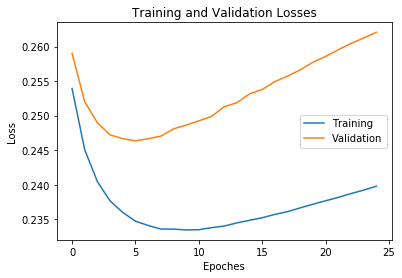

In [366]:
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [367]:
test_loss, test_acc = test(best_model, x_test, y_test)
print("Config: %r" % config)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)

Config: {'layer_specs': [784, 128, 10], 'activation': 'tanh', 'learning_rate': 0.0005, 'batch_size': 129, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 25, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}
Test Loss 0.2951137580089096
Test Accuracy 0.8521


# Tanh

In [283]:
# Customize the parameters for quik check.
config["layer_specs"]=[784, 128, 10]
config["batch_size"]=129
config["early_stop"]=True
config["early_stop_epoch"]=100
config["activation"]="tanh"
config["learning_rate"]=0.0005
config["epochs"]=100
config["L2_penalty"]=0.0001
config["momentum"]=True
config["momentum_gamma"]=0.9

In [284]:
def generate_minibatches(dataset, batch_size=64):
    X, y = dataset
    l_idx, r_idx = 0, batch_size
    while r_idx < len(X):
        yield X[l_idx:r_idx], y[l_idx:r_idx]
        l_idx, r_idx = r_idx, r_idx + batch_size
    yield X[l_idx:], y[l_idx:]

In [285]:
train_acc, valid_acc, train_loss, valid_loss, best_model=train(tra_data, tra_labels, val_data, val_labels, config)

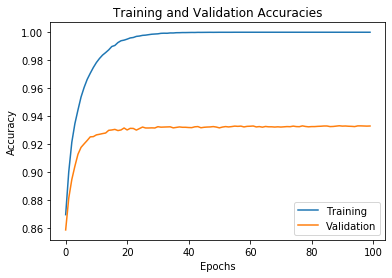

In [286]:
plt.plot(train_acc, label='Training')
plt.plot(valid_acc, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

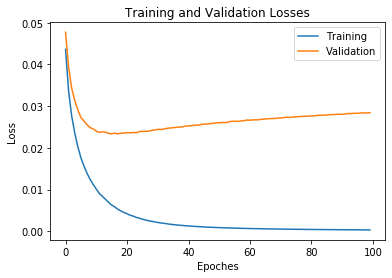

In [287]:
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [288]:
test_loss, test_acc = test(best_model, x_test, y_test)
print("Config: %r" % config)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)

Config: {'layer_specs': [784, 128, 10], 'activation': 'tanh', 'learning_rate': 0.0005, 'batch_size': 129, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 100, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}
Test Loss 0.07223660156825719
Test Accuracy 0.8515


# Sigmoid

In [289]:
# Customize the parameters for quik check.
config["layer_specs"]=[784, 128, 10]
config["batch_size"]=129
config["early_stop"]=True
config["early_stop_epoch"]=25
config["activation"]="sigmoid"
config["learning_rate"]=0.0005
config["epochs"]=100
config["L2_penalty"]=0.0001
config["momentum"]=True
config["momentum_gamma"]=0.9

In [290]:
train_acc, valid_acc, train_loss, valid_loss, best_model=train(tra_data, tra_labels, val_data, val_labels, config)

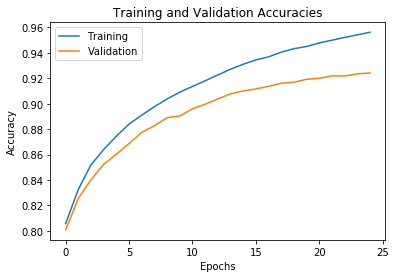

In [291]:
plt.plot(train_acc, label='Training')
plt.plot(valid_acc, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

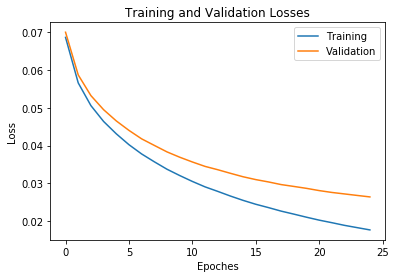

In [292]:
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [293]:
test_loss, test_acc = test(best_model, x_test, y_test)
print("Config: %r" % config)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)

Config: {'layer_specs': [784, 128, 10], 'activation': 'sigmoid', 'learning_rate': 0.0005, 'batch_size': 129, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 25, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}
Test Loss 0.05736592934362659
Test Accuracy 0.8305


# ReLU

In [299]:
# Customize the parameters for quik check.
config["layer_specs"]=[784, 128, 10]
config["batch_size"]=129
config["early_stop"]=True
config["early_stop_epoch"]=25
config["activation"]="ReLU"
config["learning_rate"]=0.0005
config["epochs"]=100
config["L2_penalty"]=0.0001
config["momentum"]=True
config["momentum_gamma"]=0.9

In [300]:
train_acc, valid_acc, train_loss, valid_loss, best_model=train(tra_data, tra_labels, val_data, val_labels, config)

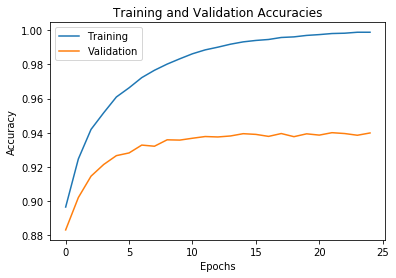

In [301]:
plt.plot(train_acc, label='Training')
plt.plot(valid_acc, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

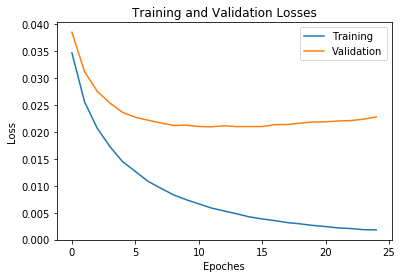

In [302]:
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [303]:
test_loss, test_acc = test(best_model, x_test, y_test)
print("Config: %r" % config)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)

Config: {'layer_specs': [784, 128, 10], 'activation': 'ReLU', 'learning_rate': 0.0005, 'batch_size': 129, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 25, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}
Test Loss 0.06158546657000908
Test Accuracy 0.8642


# Hidden units -- double

In [319]:
# Customize the parameters for quik check.
config["layer_specs"]=[784, 256, 10]
config["batch_size"]=129
config["early_stop"]=True
config["early_stop_epoch"]=25
config["activation"]="tanh"
config["learning_rate"]=0.0005
config["epochs"]=100
config["L2_penalty"]=0.0001
config["momentum"]=True
config["momentum_gamma"]=0.9

In [320]:
train_acc, valid_acc, train_loss, valid_loss, best_model=train(tra_data, tra_labels, val_data, val_labels, config)

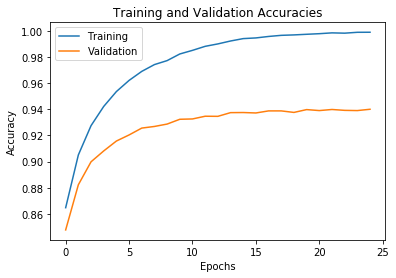

In [321]:
plt.plot(train_acc, label='Training')
plt.plot(valid_acc, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

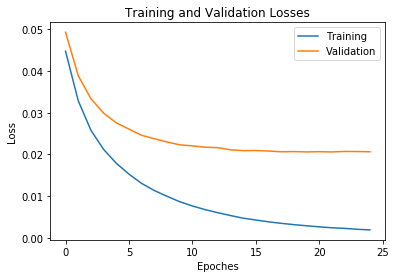

In [322]:
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [323]:
test_loss, test_acc = test(best_model, x_test, y_test)
print("Config: %r" % config)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)

Config: {'layer_specs': [784, 256, 10], 'activation': 'tanh', 'learning_rate': 0.0005, 'batch_size': 129, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 25, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}
Test Loss 0.05570371470763286
Test Accuracy 0.8589


# Hidden units -- halve

In [324]:
# Customize the parameters for quik check.
config["layer_specs"]=[784, 64, 10]
config["batch_size"]=129
config["early_stop"]=True
config["early_stop_epoch"]=25
config["activation"]="tanh"
config["learning_rate"]=0.0005
config["epochs"]=100
config["L2_penalty"]=0.0001
config["momentum"]=True
config["momentum_gamma"]=0.9

In [325]:
train_acc, valid_acc, train_loss, valid_loss, best_model=train(tra_data, tra_labels, val_data, val_labels, config)

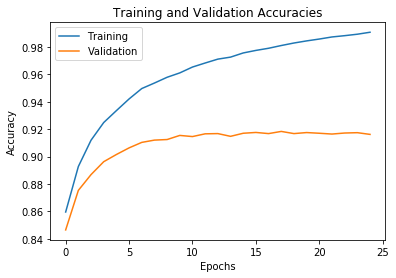

In [326]:
plt.plot(train_acc, label='Training')
plt.plot(valid_acc, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

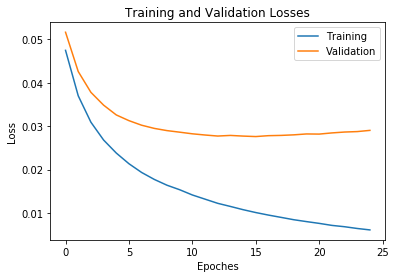

In [327]:
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [328]:
test_loss, test_acc = test(best_model, x_test, y_test)
print("Config: %r" % config)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)

Config: {'layer_specs': [784, 64, 10], 'activation': 'tanh', 'learning_rate': 0.0005, 'batch_size': 129, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 25, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}
Test Loss 0.06934423217301232
Test Accuracy 0.8274


# double layers

In [329]:
# Customize the parameters for quik check.
config["layer_specs"]=[784, 64, 64, 10]
config["batch_size"]=129
config["early_stop"]=True
config["early_stop_epoch"]=25
config["activation"]="tanh"
config["learning_rate"]=0.0005
config["epochs"]=100
config["L2_penalty"]=0.0001
config["momentum"]=True
config["momentum_gamma"]=0.9

In [330]:
train_acc, valid_acc, train_loss, valid_loss, best_model=train(tra_data, tra_labels, val_data, val_labels, config)

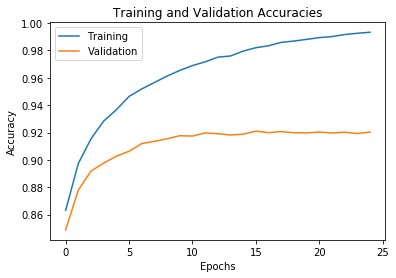

In [331]:
plt.plot(train_acc, label='Training')
plt.plot(valid_acc, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

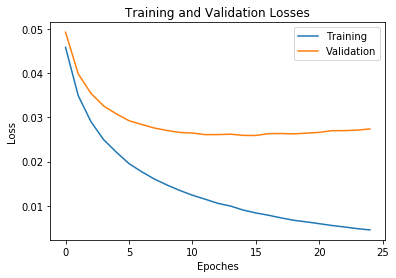

In [332]:
plt.plot(train_loss, label='Training')
plt.plot(valid_loss, label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [333]:
test_loss, test_acc = test(best_model, x_test, y_test)
print("Config: %r" % config)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)

Config: {'layer_specs': [784, 64, 64, 10], 'activation': 'tanh', 'learning_rate': 0.0005, 'batch_size': 129, 'epochs': 100, 'early_stop': True, 'early_stop_epoch': 25, 'L2_penalty': 0.0001, 'momentum': True, 'momentum_gamma': 0.9}
Test Loss 0.06985142879668356
Test Accuracy 0.8307


# regularization plot

# Experiment Functions

In [ ]:
def activation_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests all the different activation functions available and then plots their performances.
    """
    #use sigmoid as the activation function
    config['activation'] = "sigmoid"
    train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment=None)
    test_loss, test_acc = test(best_model, x_test, y_test)
    print("Config: %r" % config)
    print(f"Test Loss {config['activation']}: {test_loss}")
    print(f"Test Accuracy {config['activation']}: {test_acc}")

    #use relu as the activation function
    config['activation'] = "ReLU"
    train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment=None)
    test_loss, test_acc = test(best_model, x_test, y_test)
    print("Config: %r" % config)
    print(f"Test Loss {config['activation']}: {test_loss}")
    print(f"Test Accuracy {config['activation']}: {test_acc}")

def topology_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests performance of various network topologies, i.e. making
    the graph narrower and wider by halving and doubling the number of hidden units.

    Then, we change number of hidden layers to 2 of equal size instead of 1, and keep
    number of parameters roughly equal to the number of parameters of the best performing
    model previously.
    """
    # double the hidden units
    config['layer_specs'] = [784, 256, 10]
    train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment=None)
    test_loss, test_acc = test(best_model, x_test, y_test)
    print("Config: %r" % config)
    print(f"Test Loss {config['activation']}: {test_loss}")
    print(f"Test Accuracy {config['activation']}: {test_acc}")

    # halve the hidden units
    config['layer_specs'] = [784, 64, 10]
    train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment=None)
    test_loss, test_acc = test(best_model, x_test, y_test)
    print("Config: %r" % config)
    print(f"Test Loss {config['activation']}: {test_loss}")
    print(f"Test Accuracy {config['activation']}: {test_acc}")


def regularization_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests the neural network with regularization.
    """
    train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment="regularization")
    test_loss, test_acc = test(best_model, x_test, y_test)
    print("Config: %r" % config)
    print("Test Loss", test_loss)
    print("Test Accuracy", test_acc)

In [ ]:
for i, layer in enumerate(model.layers):
                if i%2==0:
                    if momentum:
                        if i == 0:
                            layer.d_w = new_delta(gamma,last_dw[0],layer.d_w)
                            layer.d_b = new_delta(gamma,last_db[0],layer.d_b)
                            last_dw[0],last_db[0] = layer.d_w, layer.d_b
                        else:
                            layer.d_w = new_delta(gamma,last_dw[1],layer.d_w)
                            layer.d_b = new_delta(gamma,last_db[1],layer.d_b)
                            last_dw[1],last_db[1] = layer.d_w, layer.d_b
                        if experiment=="regularization":
                            layer.w += learning_rate*layer.d_w/batch_size - L2_pen*layer.w
                        else:
                            layer.w += learning_rate*layer.d_w/batch_size
                        layer.b += learning_rate*layer.d_b/batch_size
                    else:
                        if experiment=="regularization":
                            layer.w += learning_rate*layer.d_w/batch_size - L2_pen*layer.w
                        else:
                            layer.w += learning_rate*layer.d_w/batch_size
                        layer.b += learning_rate*layer.d_b/batch_size

# Check Gradient

In [173]:
def check_gradients(x_train, y_train, config):
    """
    Check the network gradients computed by back propagation by comparing with the gradients computed using numerical
    approximation.
    """
    model = NeuralNetwork(config=config)
    #for one pattern
    x, y = x_train[5:6], y_train[5:6]
    error = 10e-2
    # input to hidden units is 0, hidden units to output is 2
    cur_layer = model.layers[0]
    
    # Initialize weight value to use
    weight = cur_layer.w[12,11]
    #weight = cur_layer.b[2]

    # add error
    cur_layer.w[12, 11] = weight + error
    #cur_layer.b[2] = weight + error
    predicted_y, loss_plus = model(x, y)

    # subtract error
    cur_layer.w[12,11] = weight - error
    #cur_layer.b[2] = weight - error
    predicted_y, loss_minus = model(x, y)
    
    # compute the approximated gradient and the actual
    approximated = (np.abs((loss_plus - loss_minus) / (2 * error)))
    model.backward()
    actual = np.abs(cur_layer.d_w[12,11])/10
    #actual = np.abs(cur_layer.d_b[2])/10
    
    #print out
    print("Approximated gradient: ",str(approximated))
    print("Actual gradient: ",str(actual))
    print("Difference: ",str(np.abs(actual - approximated)))

In [174]:
def train_check_gradient(x_train_in, y_train_in, x_val, y_val, config, experiment=None):
    model = NeuralNetwork(config=config)  
    y_train_in=one_hot_encoding(y_train_in)
    train_dataset=(x_train_in,y_train_in)
    #check gradients
    check_gradients(x_train_in,y_train_in, config)

In [175]:
#check gradient
train_check_gradient(tra_data, tra_labels, val_data, val_labels, config)

Approximated gradient:  0.0007960504499035514
Actual gradient:  0.0007925962829981818
Difference:  3.4541669053696905e-06


# Activation

In [ ]:
def activation_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests all the different activation functions available and then plots their performances.
    """
    #use sigmoid as the activation function
    config['activation'] = "sigmoid"
    train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment=None)
    test_loss, test_acc = test(best_model, x_test, y_test)
    return train_acc, valid_acc, train_loss, valid_loss,test_loss, test_acc

    # #use relu as the activation function
    # config['activation'] = "ReLU"
    # train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment=None)
    # test_loss, test_acc = test(best_model, x_test, y_test)
    # return train_acc, valid_acc, train_loss, valid_loss,test_loss, test_acc


def topology_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests performance of various network topologies, i.e. making
    the graph narrower and wider by halving and doubling the number of hidden units.

    Then, we change number of hidden layers to 2 of equal size instead of 1, and keep
    number of parameters roughly equal to the number of parameters of the best performing
    model previously.
    """
    # double the hidden units
    config['layer_specs'] = [784, 256, 10]
    train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment=None)
    test_loss, test_acc = test(best_model, x_test, y_test)
    return train_acc, valid_acc, train_loss, valid_loss,test_loss, test_acc

    # halve the hidden units
    # config['layer_specs'] = [784, 64, 10]
    # train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment=None)
    # test_loss, test_acc = test(best_model, x_test, y_test)
    # return train_acc, valid_acc, train_loss, valid_loss,test_loss, test_acc


def regularization_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests the neural network with regularization.
    """
    train_acc, valid_acc, train_loss, valid_loss, best_model = train(x_train,y_train,x_val,y_val,config,experiment="regularization")
    test_loss, test_acc = test(best_model, x_test, y_test)
    return train_acc, valid_acc, train_loss, valid_loss,test_loss, test_acc



def check_gradients(x_train, y_train, config):
    """
    Check the network gradients computed by back propagation by comparing with the gradients computed using numerical
    approximation.
    """
    model = NeuralNetwork(config=config)
    #for one pattern
    x, y = x_train[5:6], y_train[5:6]
    error = 10e-2
    # input to hidden units is 0, hidden units to output is 2
    cur_layer = model.layers[0]
    
    # Initialize weight value to use
    weight = cur_layer.w[0,1]
    # weight = cur_layer.b[2]

    # add error
    cur_layer.w[0, 1] = weight + error
    # cur_layer.b[2] = weight + error
    predicted_y, loss_plus = model(x, y)

    # subtract error
    cur_layer.w[0,1] = weight - error
    # cur_layer.b[2] = weight - error
    predicted_y, loss_minus = model(x, y)
    
    # compute the approximated gradient and the actual
    approximated = (np.abs((loss_plus - loss_minus) / (2 * error)))
    model.backward()
    actual = np.abs(cur_layer.d_w[0,1])
    # actual = np.abs(cur_layer.d_b[2])/10
    
    #print out
    print("Approximated gradient: ",str(approximated), " Actual gradient: ", str(actual), " Difference: ",str(np.abs(actual - approximated)))

In [ ]:
def activation_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests all the different activation functions available and then plots their performances.
    """
    # A list that records all possible outputs
    output=[]
    
    config["early_stop"]=True
    config["early_stop_epoch"]=5
    
    
    # tanh:
    config["activation"]="tanh"
    train_acc, valid_acc, train_loss, valid_loss, model=train(tra_data, tra_labels, val_data, val_labels, config)
    output.append([train_acc, valid_acc, train_loss, valid_loss, model])
    
    
    
    # sigmoid:
    config["activation"]="sigmoid"
    train_acc, valid_acc, train_loss, valid_loss, model=train(tra_data, tra_labels, val_data, val_labels, config)
    output.append([train_acc, valid_acc, train_loss, valid_loss, model])
    
    
    
    # relu:
    config["activation"]="ReLU"
    train_acc, valid_acc, train_loss, valid_loss, model=train(tra_data, tra_labels, val_data, val_labels, config)
    output.append([train_acc, valid_acc, train_loss, valid_loss, model])
    
    
    # Visualization 
    output=np.array(output)
    
    ## Training losses:
    training_losses=output[:,2]
    plt.plot(training_losses[0],label="tanh")
    plt.plot(training_losses[1],label="sigmoid")
    plt.plot(training_losses[2],label="ReLu")
    plt.title("training losses")
    plt.show()
    
    ## Training accuracy:
    training_acc=output[:,0]
    plt.plot(training_acc[0],label="tanh")
    plt.plot(training_acc[1],label="sigmoid")
    plt.plot(training_acc[2],label="ReLu")
    plt.title("training accuracy")
    plt.show()
    
    
    ## Validation Accuracy: 
    val_acc=output[:,1]
    plt.plot(val_acc[0],label="tanh")
    plt.plot(val_acc[1],label="sigmoid")
    plt.plot(val_acc[2],label="ReLu")
    plt.title("validation accuracy")
    plt.show()
    
    ## Validation Losses:
    val_losses=output[:,3]
    plt.plot(val_losses[0],label="tanh")
    plt.plot(val_losses[1],label="sigmoid")
    plt.plot(val_losses[2],label="ReLu")
    plt.title("validation losses")
    plt.show()
    
    ## Test outcome
    models=output[:,4]
    test1=test(models[0], x_test, y_test)
    test2=test(models[1], x_test, y_test)
    test3=test(models[2], x_test, y_test)
    return (test1,test2,test3)
        


def topology_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests performance of various network topologies, i.e. making
    the graph narrower and wider by halving and doubling the number of hidden units.

    Then, we change number of hidden layers to 2 of equal size instead of 1, and keep
    number of parameters roughly equal to the number of parameters of the best performing
    model previously.
    """
    raise NotImplementedError('Topology Experiment not implemented')


def regularization_experiment(x_train, y_train, x_val, y_val, x_test, y_test, config):
    """
    This function tests the neural network with regularization.
    """
    raise NotImplementedError('Regularization Experiment not implemented')
